In [78]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision

from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import numpy as np


In [79]:
train_transform = transforms.Compose(
    [
         transforms.RandomVerticalFlip(0.5)
        ,transforms.RandomRotation(24)
        ,transforms.ToTensor()
        ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ] 
)


In [80]:
trainset = ImageFolder("data/train/", transform=train_transform)


In [81]:
classes = []

for image in trainset.imgs:
    the_class = image[0].split("/")[2].split("\\")[0]
    if the_class not in classes:
        classes.append(the_class)

print(len(classes))
print(classes)


50
['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']


In [82]:
from random import shuffle

all_data = list(trainset)
shuffle(all_data)

trainset = all_data


In [83]:
n = len(trainset)
n_test = int(0.25 * len(trainset))
validset = Subset(trainset, range(n_test))
trainset = Subset(trainset, range(n_test, n))

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


In [84]:
_classes = list()

for cls in range(len(validset)):
    _classes.append(classes[validset[cls][1]])

len(set(_classes)) 


50

In [85]:
images, labels = next(iter(trainloader))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


antenna


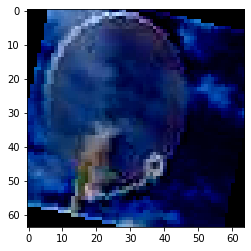

In [86]:
print(classes[labels[1]])
plt.imshow(np.transpose(images[1].numpy(), (1, 2, 0)))


In [87]:
class BestNetEver(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 50)
        )
    
    def forward(self, x):
        return self.network(x)


net = BestNetEver()
net


BestNetEver(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [88]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [89]:
epochs = 10


In [90]:
len(trainset)


66009

In [91]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f"[{epoch+1}/{epochs}] loss: {running_loss/len(trainset)}")
    running_loss = 0.0
    torch.save(net.state_dict(), f'./supercnn{epoch+1}.pt')

print('Finished Training')



[1/10] loss: 0.10506939175731801
[2/10] loss: 0.09015502571241533
[3/10] loss: 0.08113946520468975
[4/10] loss: 0.07409880079078325
[5/10] loss: 0.06709728273799061
[6/10] loss: 0.059192842604577287
[7/10] loss: 0.04971425832884568
[8/10] loss: 0.04026810674638174
[9/10] loss: 0.031765536789687576
[10/10] loss: 0.024823224999264638
Finished Training


In [92]:
torch.save(net.state_dict(), './supercnn.pt')

In [131]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)   
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


total_accuracy = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is: {accuracy}")
    total_accuracy += accuracy

print('\nTotal accuracy:', total_accuracy/50)



Accuracy for class acoustic is: 16.375545851528383
Accuracy for class antenna is: 18.609865470852018
Accuracy for class bacteria is: 28.935185185185187
Accuracy for class battery is: 19.07894736842105
Accuracy for class bean is: 27.130044843049326
Accuracy for class beetle is: 40.52287581699346
Accuracy for class bicycle is: 30.021598272138228
Accuracy for class birch is: 17.937219730941703
Accuracy for class bird is: 15.49586776859504
Accuracy for class bomb is: 32.04545454545455
Accuracy for class bread is: 24.56140350877193
Accuracy for class bridge is: 24.08256880733945
Accuracy for class camera is: 44.27312775330397
Accuracy for class carbon is: 11.206896551724139
Accuracy for class cat is: 19.517543859649123
Accuracy for class corn is: 31.46551724137931
Accuracy for class crab is: 11.136890951276103
Accuracy for class crocodilian is: 23.543123543123542
Accuracy for class echinoderm is: 18.973214285714285
Accuracy for class egg is: 27.19298245614035
Accuracy for class elephant is:

In [98]:
import os

names = os.listdir("data/test_all/")
img_loc = os.path.join("data/test_all/", names[0])
torchvision.io.read_image(img_loc).shape


torch.Size([3, 64, 64])

In [99]:
images = []
with torch.no_grad():
    for name in os.listdir("data/test_all/"):
        img_loc = os.path.join("data/test_all/", name)
        image = torchvision.io.read_image(img_loc).float()
        if image.shape[0] != 3:
            image = image.expand(3, 64, 64)
        images.append(image)



In [96]:
from torch.utils import data
images = torch.stack(images) 

test_dataset = data.TensorDataset(images)

test_dataset_loader = data.DataLoader(test_dataset, batch_size=32)


In [147]:
import pandas as pd

all_preds = torch.tensor([])

with torch.no_grad():
    for data in test_dataset_loader:
        images = data[0]
        outputs = net(images)   
        _, predictions = torch.max(outputs, 1)

        all_preds = torch.cat((all_preds, predictions))

all_preds = pd.Series(all_preds)
all_names = pd.Series(os.listdir("data/test_all/"))

data = [all_names, all_preds]
results = pd.DataFrame(data=data)

results.T.to_csv('results.csv', index=False, header=False)
